In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import tensorflow as tf
import keras 
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model
from keras.utils import multi_gpu_model
import cv2
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import random
import pandas as pd
from keras import losses
from skimage.io import imsave, imread

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
pwd

'/home/ubuntu/gcubme4/Workspace/JW_Seo/p_project/code'

In [77]:
def base_block(inputs, filters = 4, scale = 2):
    
#     x = Conv2D(filters, 3, strides= 1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation(activation='relu')(x)
   
    x = Conv2D(filters, 3, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    base_out = Activation(activation='relu')(x)

    
    return base_out

def bottleneck(imputs, filters):

    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 3, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    

    return x

def residual_block(inputs, filters):
    
    shortcut = inputs
    print('input')
    print('shortcut:',shortcut.shape)
    print('x:',inputs.shape)
    
    x = Conv2D(filters, kernel_size=3, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(filters, kernel_size=1, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization()(shortcut)
#     shrotcut = Activation(activation='relu')(shrotcut)
    print('before add')
    print('shortcut:',shortcut.shape)
    print('x:',x.shape)
    x = add([x, shortcut])
    
    res_out = Activation(activation='relu')(x)
    
    return res_out

def base_classification_jw(inputs, filters = 4, scale = 2):
    
    layer=2
    for br in range(layer):
        
        if br == 0:
            print(br)
            conv= base_block(inputs)
            
            conv = MaxPooling2D(pool_size=(3, 3), strides = 2)(conv)
            print(conv.shape)
            
        else:
            print(br)
            print(conv.shape, scale, br, filters)
            num = (scale**br) *  filters
            conv= residual_block(conv, filters= num)
            print(conv.shape)
            print(num)
    
            conv= MaxPooling2D(pool_size=(2, 2), strides = 2)(conv)
            print(conv.shape)
    for ar in range(layer):
        print(num)
        num = int(num/scale)
        conv = base_block(conv, filters = num)
        print(num)    
        
            
    out= Flatten()(conv)
  
    out = Dense(1, activation="sigmoid")(out)
    
    
    
    model = Model(inputs=inputs, outputs=out)
    
    return model           

In [78]:
from keras.models import Sequential

input_img = Input(shape=(32,32,1))
model = base_classification_jw(input_img, filters = 4, scale = 2)
model.summary()

0
(None, 15, 15, 4)
1
(None, 15, 15, 4) 2 1 4
input
shortcut: (None, 15, 15, 4)
x: (None, 15, 15, 4)
before add
shortcut: (None, 15, 15, 8)
x: (None, 15, 15, 8)
(None, 15, 15, 8)
8
(None, 7, 7, 8)
8
4
4
2
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 32, 32, 4)    40          input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 32, 32, 4)    16          conv2d_65[0][0]                  
_____________________________________________________________________________________

In [79]:
print("loading data")

img_train = np.load('../train_img_32_bilinear.npy')
img_test = np.load('../test_img_32_bilinear.npy')
lab_train= np.load('../train_label_32_bilinear.npy')
lab_test= np. load('../test_label_32_bilinear.npy')


print("loading data done")
print(img_train.shape)
print(img_test.shape)
print(lab_train.shape)
print(lab_test.shape)

loading data
loading data done
(70, 32, 32, 1)
(32, 32, 32, 1)
(70,)
(32,)


In [26]:
help(model.compile)

Help on method compile in module keras.engine.training:

compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, **kwargs) method of keras.engine.training.Model instance
    Configures the model for training.
    
    # Arguments
        optimizer: String (name of optimizer) or optimizer instance.
            See [optimizers](/optimizers).
        loss: String (name of objective function) or objective function or
            `Loss` instance. See [losses](/losses).
            If the model has multiple outputs, you can use a different loss
            on each output by passing a dictionary or a list of losses.
            The loss value that will be minimized by the model
            will then be the sum of all individual losses.
        metrics: List of metrics to be evaluated by the model
            during training and testing. Typically you will use
            `metrics=['accuracy']`. To specify different me

In [80]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./residual_class_32_bilinear_1.h5', verbose=1, save_best_only=True, monitor='loss')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, min_lr=0, min_delta=0.001, verbose=1)
earlystopper = EarlyStopping(patience=30, verbose=1, monitor='loss')
callbacks_list = [reduce_lr, checkpointer, earlystopper]


In [81]:
# results = model.fit(img_train, lab_train, batch_size=4, epochs=500, verbose=1, validation_split=0.1, shuffle=True, callbacks=callbacks_list)
results = model.fit(img_train, lab_train, batch_size=128, epochs=500, verbose=1, shuffle=False,  callbacks=callbacks_list)

Epoch 1/500
70/70 [==============================] - 1s 11ms/step - loss: 1.1820 - accuracy: 0.4000

Epoch 00001: loss improved from inf to 1.18199, saving model to ./residual_class_32_bilinear_1.h5
Epoch 2/500
70/70 [==============================] - 0s 180us/step - loss: 1.1130 - accuracy: 0.4143

Epoch 00002: loss improved from 1.18199 to 1.11304, saving model to ./residual_class_32_bilinear_1.h5
Epoch 3/500
70/70 [==============================] - 0s 147us/step - loss: 1.0387 - accuracy: 0.4429

Epoch 00003: loss improved from 1.11304 to 1.03873, saving model to ./residual_class_32_bilinear_1.h5
Epoch 4/500
70/70 [==============================] - 0s 162us/step - loss: 0.9677 - accuracy: 0.5286

Epoch 00004: loss improved from 1.03873 to 0.96768, saving model to ./residual_class_32_bilinear_1.h5
Epoch 5/500
70/70 [==============================] - 0s 181us/step - loss: 0.9037 - accuracy: 0.5571

Epoch 00005: loss improved from 0.96768 to 0.90366, saving model to ./residual_class_32

In [46]:
# model = load_model('basic_class_32_bilinear_1.h5')

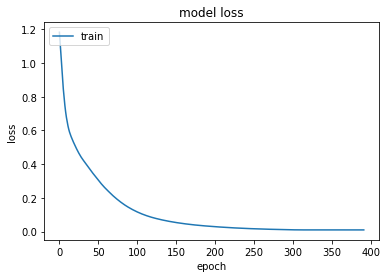

In [82]:
fig = plt.figure()
plt.axes(facecolor='white')
plt.plot(results.history['loss'])
# plt.plot(results.history['accuracy'])
# plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'acc'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.savefig('./result_img/residual/res_loss_1',dpi=200, facecolor='w', edgecolor='w')
plt.show()

In [83]:
test_results= model.predict(img_test, batch_size=128, verbose=1)

32/32 [==============================] - 0s 4ms/step


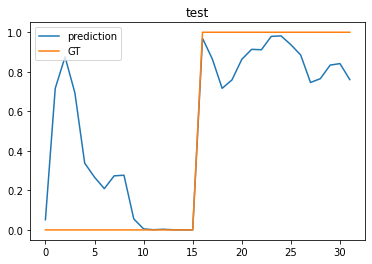

In [84]:
fig = plt.figure()
# plt.axes(facecolor='white')
plt.plot(test_results)
plt.plot(lab_test)
plt.title('test')
plt.legend(['prediction', 'GT'], loc='upper left')
plt.savefig('./result_img/residual/res_results_1',dpi=200, facecolor='w', edgecolor='w')
plt.show()

In [85]:
score= model.evaluate(img_test, lab_test)
print("loss: %.2f, 정확도: %.2f  " %(score[0], score[1]))

32/32 [==============================] - 0s 4ms/step
loss: 0.27, 정확도: 0.91  


In [86]:
print(test_results)

[[5.14972545e-02]
 [7.16066182e-01]
 [8.75271738e-01]
 [6.93550110e-01]
 [3.37935448e-01]
 [2.66716331e-01]
 [2.08829299e-01]
 [2.73493409e-01]
 [2.76707232e-01]
 [5.56219220e-02]
 [5.19505283e-03]
 [1.07401051e-03]
 [3.32321576e-03]
 [8.99633626e-04]
 [1.14074195e-04]
 [1.47432482e-04]
 [9.69392836e-01]
 [8.64696085e-01]
 [7.16209531e-01]
 [7.58749425e-01]
 [8.62737477e-01]
 [9.13392127e-01]
 [9.11519885e-01]
 [9.79026794e-01]
 [9.81536567e-01]
 [9.37070131e-01]
 [8.84714425e-01]
 [7.45829403e-01]
 [7.65052259e-01]
 [8.33738089e-01]
 [8.41343760e-01]
 [7.60394335e-01]]


/home/ubuntu/anaconda3/envs/zzaem1/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


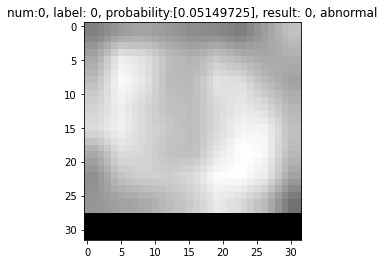

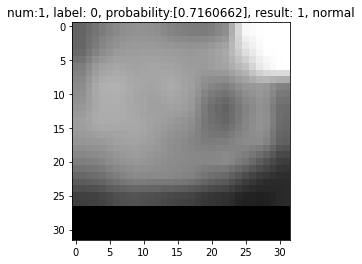

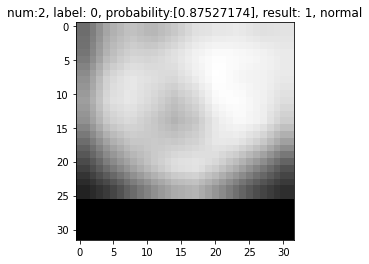

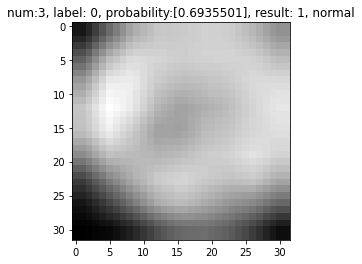

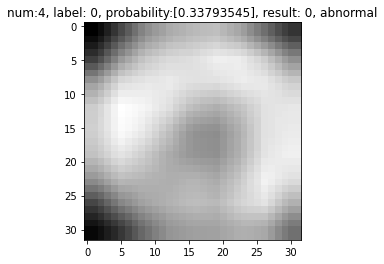

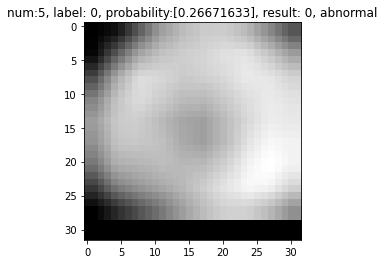

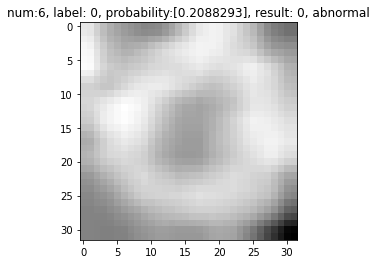

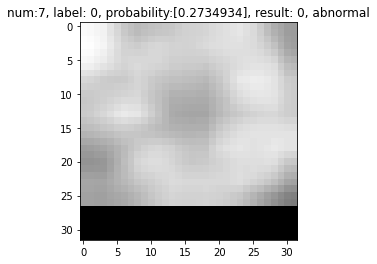

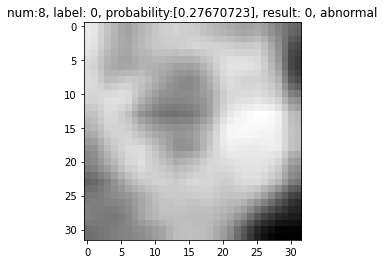

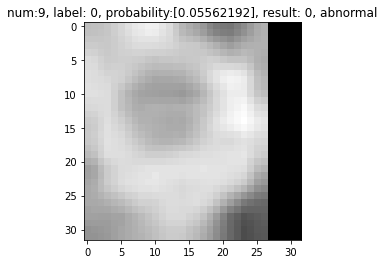

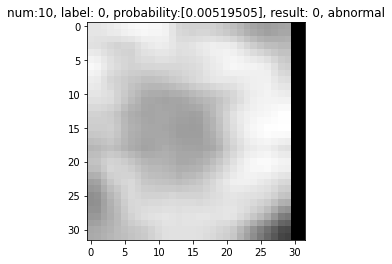

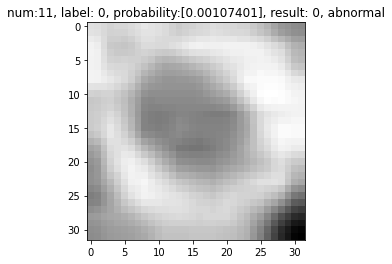

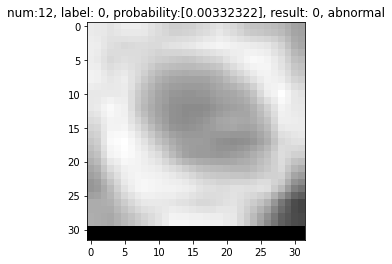

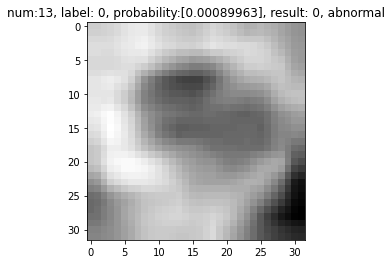

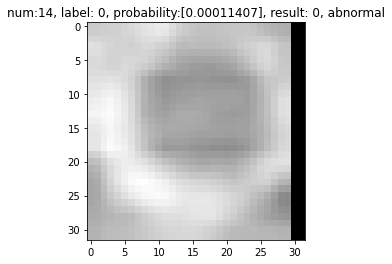

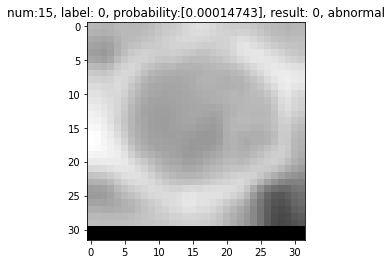

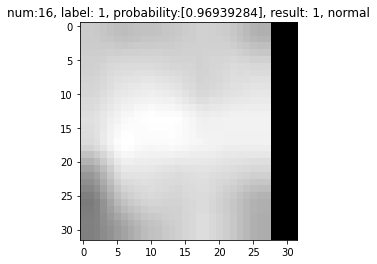

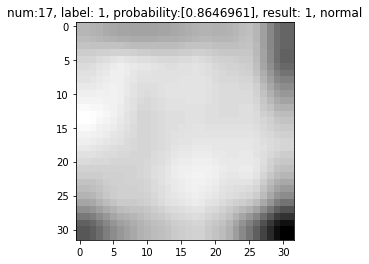

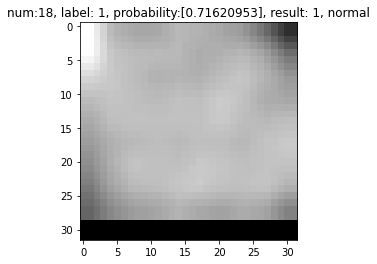

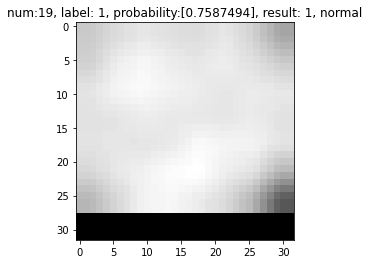

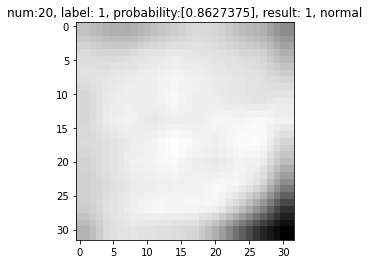

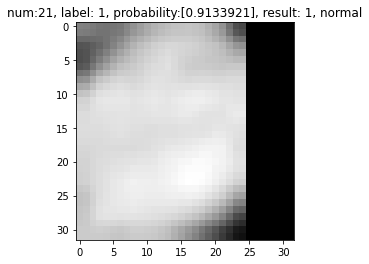

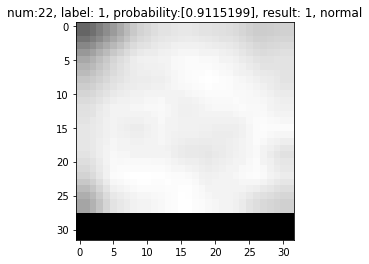

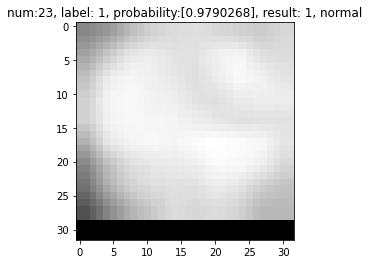

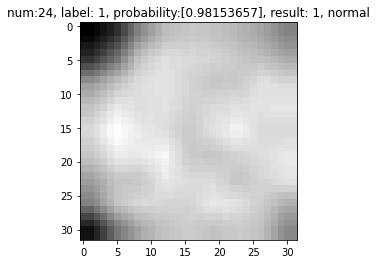

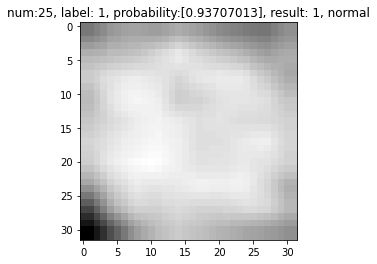

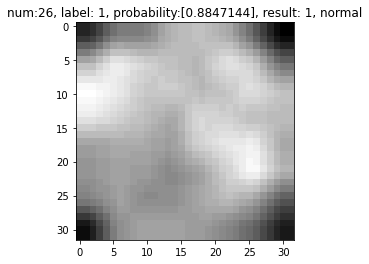

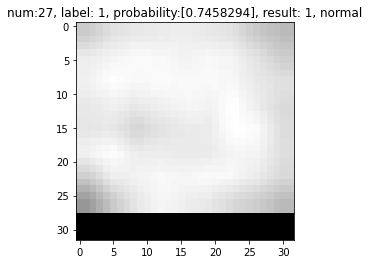

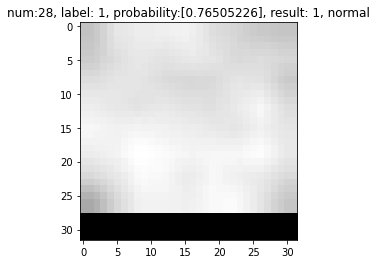

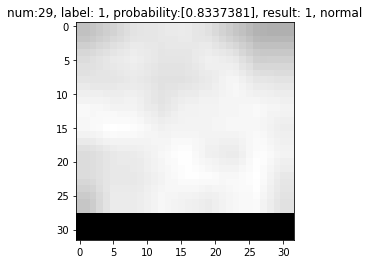

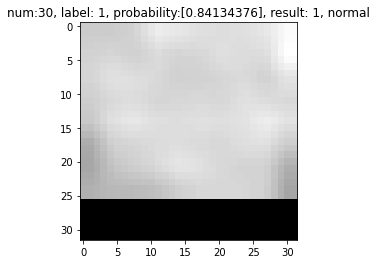

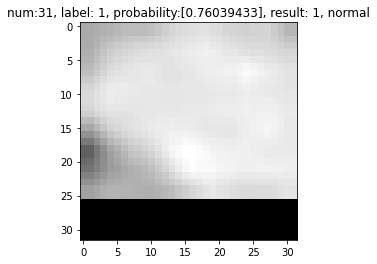

In [88]:
for i in range(len(img_test)):
    if i<16:
#         label= 'label: 0'
        if test_results[i]<0.5:

            plt.figure()
            plt.title("num:"+ str(i)+', label: 0, probability:'+str(test_results[i])+ ', result: 0, abnormal')
            plt.imshow(img_test[i,:,:,0],cmap='gray')
            plt.savefig('./result_img/residual/'+str(i),dpi=200, facecolor='w', edgecolor='w')
            
        else:

            plt.figure()
            plt.title("num:"+ str(i)+', label: 0, probability:'+str(test_results[i])+ ', result: 1, normal')
            plt.imshow(img_test[i,:,:,0],cmap='gray')
            plt.savefig('./result_img/residual/'+str(i),dpi=200, facecolor='w', edgecolor='w')
            
    else:
        label= 'label: 1'
        if test_results[i]<0.5:

            plt.figure()
            plt.title("num:"+ str(i)+', label: 1, probability:'+str(test_results[i])+ ', result: 0, abnormal')
            plt.imshow(img_test[i,:,:,0],cmap='gray')
            plt.savefig('./result_img/residual/'+str(i),dpi=200, facecolor='w', edgecolor='w')
            
        else:

            plt.figure()
            plt.title("num:"+ str(i)+', label: 1, probability:'+str(test_results[i])+ ', result: 1, normal')
            plt.imshow(img_test[i,:,:,0],cmap='gray')
            plt.savefig('./result_img/residual/'+str(i),dpi=200, facecolor='w', edgecolor='w')